In [ ]:
!pip install pystan
!pip install prophet

In [ ]:
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import pickle

# Data gathering and manipulation


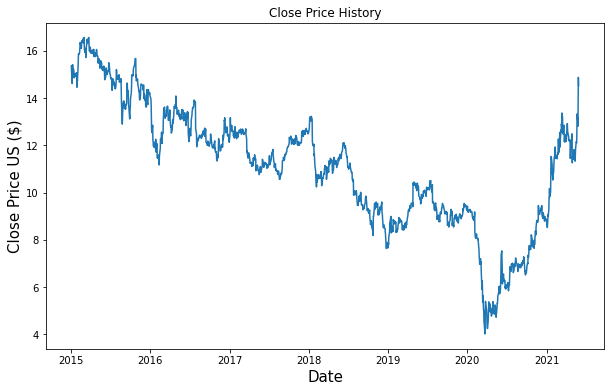

In [ ]:
# getteing ford data set
df = pdr.DataReader("F", data_source='yahoo', start='2015-01-01')

# visualize Line pattern of 'Close' Feature to see how it looks like
plt.figure(figsize=(10, 6))
plt.plot(df['Close'])
plt.title("Close Price History")
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price US ($)', fontsize=15)
plt.show()
# Convert the date index into a datetime 
df.index = pd.to_datetime(df.index, format="%Y/%m/%d")


#Adding Holidays to the model

In [ ]:
import holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [ ]:
holiday.head()

,ds,holiday
0,2012-01-01,US-Holidays
1,2012-01-02,US-Holidays
2,2012-01-16,US-Holidays
3,2012-02-20,US-Holidays
4,2012-05-28,US-Holidays


In [ ]:
# data frame modification to be accepted by prophet as an input
data = df['Close'].reset_index()
data.columns = ['ds', 'y']
data

,ds,y
0,2015-01-02,15.36
1,2015-01-05,14.76
2,2015-01-06,14.62
3,2015-01-07,15.04
4,2015-01-08,15.42
...,...,...
1608,2021-05-24,13.06
1609,2021-05-25,12.81
1610,2021-05-26,13.90
1611,2021-05-27,14.88


# Model training 

In [ ]:
import json
from prophet.serialize import model_to_json, model_from_json
m = Prophet(holidays=holiday,seasonality_mode='additive', changepoint_prior_scale = 0.1, seasonality_prior_scale=0.01)
m.fit(data)

with open('F_prophet.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Diagnostics and evaluation

In [ ]:
from prophet.diagnostics import cross_validation
# setting 80 % of the data as initial (training data),
# and 20 days to forecast per iteration
# For each ordered validation iteration, FBProphet will forecast between 
# the cutoff (period) and the cutoff + horizon and then add the period to get the next cutoff
data_cv = cross_validation(m, initial='1752 days', period = '10 days', horizon = '20 days' ,parallel="threads")


INFO:prophet:Making 57 forecasts with cutoffs between 2019-10-26 00:00:00 and 2021-05-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7f08c3a27950>


In [ ]:
data_cv[['ds', 'yhat', 'y']].tail()

,ds,yhat,y
780,2021-05-24,11.101219,13.06
781,2021-05-25,11.143807,12.81
782,2021-05-26,11.145634,13.90
783,2021-05-27,11.167647,14.88
784,2021-05-28,11.204582,14.53


In [ ]:
from prophet.diagnostics import performance_metrics
data_p = performance_metrics(data_cv, rolling_window=0.1 )
data_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,3.126406,1.768165,1.424170,0.172455,0.167064,0.179896,0.278764
1,3 days,3.680472,1.918456,1.532704,0.189442,0.177614,0.196008,0.252564
2,4 days,3.781068,1.944497,1.569486,0.197054,0.185522,0.203029,0.205128
3,5 days,3.407456,1.845930,1.500627,0.188778,0.183765,0.193162,0.212689
4,6 days,3.633503,1.906175,1.530799,0.191360,0.183765,0.196315,0.237961
5,7 days,4.057403,2.014300,1.612444,0.196945,0.192177,0.205413,0.252033
6,8 days,4.123322,2.030596,1.647452,0.201666,0.186538,0.209712,0.227811
7,9 days,4.254916,2.062745,1.678941,0.215323,0.186287,0.216832,0.212689
8,10 days,4.389330,2.095073,1.708492,0.220604,0.191508,0.222031,0.199500
9,11 days,4.293039,2.071965,1.710227,0.211934,0.198227,0.219615,0.190007


In [ ]:
print("MAE value --> ", data_p['mae'].mean())
print("MAPE value --> ", data_p['mape'].mean())
print("MSE value --> ", data_p['mse'].mean())

MAE value -->  1.739511672916423
MAPE value -->  0.21704630297853655
MSE value -->  4.576492238703272


In [ ]:
pip install datetime

In [ ]:
with open('F_prophet.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model
future = m.make_future_dataframe(periods=1)
model_prediction = m.predict(future)
print(float(model_prediction[ 'yhat'][-1:]))

12.218988649989587


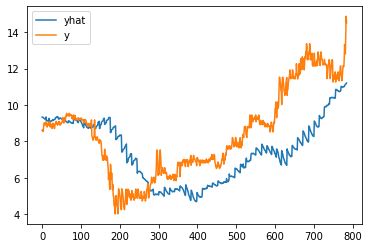

In [ ]:
fig3 = data_cv[['yhat', 'y']].plot()

# Model tuning

In [ ]:
import itertools
import numpy as np
import pandas as pd
param_grid = {  
    'seasonality_mode':('multiplicative','additive'),
    'changepoint_prior_scale': [0.001, 0.005, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
    
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params).fit(data)  # Fit model with given params
    df_cv = cross_validation(model, initial='1752 days', period = '10 days', horizon = '20 days' ,parallel="threads")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 57 forecasts with cutoffs between 2019-10-26 00:00:00 and 2021-05-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7f08e66ac990>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 57 forecasts with cutoffs between 2019-10-26 00:00:00 and 2021-05-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7f08e611fc10>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 57 forecasts with cutoffs between 2019-10-26 00:00:00 and 2021-05-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7f08e5f8dbd0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonal

   seasonality_mode  changepoint_prior_scale  seasonality_prior_scale      rmse
0    multiplicative                    0.001                     0.01  2.813118
1    multiplicative                    0.001                     0.10  2.820664
2    multiplicative                    0.001                     1.00  2.822476
3    multiplicative                    0.001                    10.00  2.820298
4    multiplicative                    0.005                     0.01  2.701087
5    multiplicative                    0.005                     0.10  2.711639
6    multiplicative                    0.005                     1.00  2.701085
7    multiplicative                    0.005                    10.00  2.688972
8    multiplicative                    0.010                     0.01  2.547791
9    multiplicative                    0.010                     0.10  2.560821
10   multiplicative                    0.010                     1.00  2.517175
11   multiplicative                    0

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}


# Trying the best model

In [ ]:
final_m = Prophet(seasonality_mode='additive', changepoint_prior_scale = 0.1, seasonality_prior_scale=0.01)
final_m.fit(data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
from prophet.diagnostics import cross_validation
# setting 80 % of the data as initial (training data),
# and 20 days to forecast per iteration
# For each ordered validation iteration, FBProphet will forecast between 
# the cutoff (period) and the cutoff + horizon and then add the period to get the next cutoff
data_final_cv = cross_validation(final_m, initial='1752 days', period = '10 days', horizon = '20 days' ,parallel="threads")


INFO:prophet:Making 57 forecasts with cutoffs between 2019-10-26 00:00:00 and 2021-05-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7f08db24d8d0>


In [ ]:
final_p = performance_metrics(data_final_cv, rolling_window=0.1 )
final_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,3.148350,1.774359,1.431920,0.173517,0.172303,0.181000,0.278764
1,3 days,3.698606,1.923176,1.537161,0.190130,0.178731,0.196571,0.252564
2,4 days,3.797960,1.948835,1.573244,0.197850,0.184093,0.203692,0.205128
3,5 days,3.427607,1.851380,1.506627,0.190002,0.186726,0.194300,0.225510
4,6 days,3.658984,1.912847,1.537063,0.192725,0.186726,0.197466,0.250156
5,7 days,4.090687,2.022545,1.620831,0.198435,0.194272,0.206796,0.252971
6,8 days,4.160970,2.039846,1.657623,0.203255,0.187918,0.211316,0.227811
7,9 days,4.278554,2.068466,1.684875,0.216339,0.185153,0.217690,0.212689
8,10 days,4.401877,2.098065,1.711179,0.221180,0.190620,0.222279,0.199500
9,11 days,4.312924,2.076758,1.715154,0.212881,0.200548,0.220452,0.202827


In [ ]:
print("MAE value --> ", final_p['mae'].mean())
print("MAPE value --> ", final_p['mape'].mean())
print("MSE value --> ", final_p['mse'].mean())

MAE value -->  1.7468740261043993
MAPE value -->  0.2184083119975996
MSE value -->  4.604738554954044
